In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu = pd.read_csv('gpu.csv')

In [3]:
gpu.shape

(786, 17)

In [4]:
gpu.dtypes

manufacturer     object
GPU              object
releaseYear       int64
memSize         float64
memBusWidth     float64
gpuClock          int64
memClock        float64
tmu               int64
rop               int64
igp              object
bus              object
memType          object
gpuChip          object
G3Dmark           int64
G2Dmark           int64
testDate          int64
category         object
dtype: object

Since my end goal is a model that can predict 3Dmark score based on GPU features, I want to begin understanding which features are most correltated to the feature in question. Let's call .corr() and make a heatmap. 

In [5]:
gpu_only_numeric = gpu.drop(['manufacturer', 'GPU', 'memType', 'category','bus', 'igp','gpuChip'], axis = 1)

In [6]:
gpu_only_numeric.corr()

,releaseYear,memSize,memBusWidth,gpuClock,memClock,tmu,rop,G3Dmark,G2Dmark,testDate
releaseYear,1.000000,0.561660,0.208437,0.850285,0.816294,0.574481,0.580491,0.646283,0.667659,0.897097
memSize,0.561660,1.000000,0.496480,0.582586,0.489305,0.826662,0.802390,0.803846,0.623867,0.577651
memBusWidth,0.208437,0.496480,1.000000,0.231776,0.015336,0.562036,0.480692,0.421657,0.332748,0.220329
gpuClock,0.850285,0.582586,0.231776,1.000000,0.809153,0.608489,0.623536,0.723147,0.679321,0.801310
memClock,0.816294,0.489305,0.015336,0.809153,1.000000,0.581074,0.584139,0.626250,0.655443,0.754478
tmu,0.574481,0.826662,0.562036,0.608489,0.581074,1.000000,0.914365,0.886571,0.718883,0.592530
rop,0.580491,0.802390,0.480692,0.623536,0.584139,0.914365,1.000000,0.909090,0.737910,0.588935
G3Dmark,0.646283,0.803846,0.421657,0.723147,0.626250,0.886571,0.909090,1.000000,0.798830,0.658938
G2Dmark,0.667659,0.623867,0.332748,0.679321,0.655443,0.718883,0.737910,0.798830,1.000000,0.667502
testDate,0.897097,0.577651,0.220329,0.801310,0.754478,0.592530,0.588935,0.658938,0.667502,1.000000


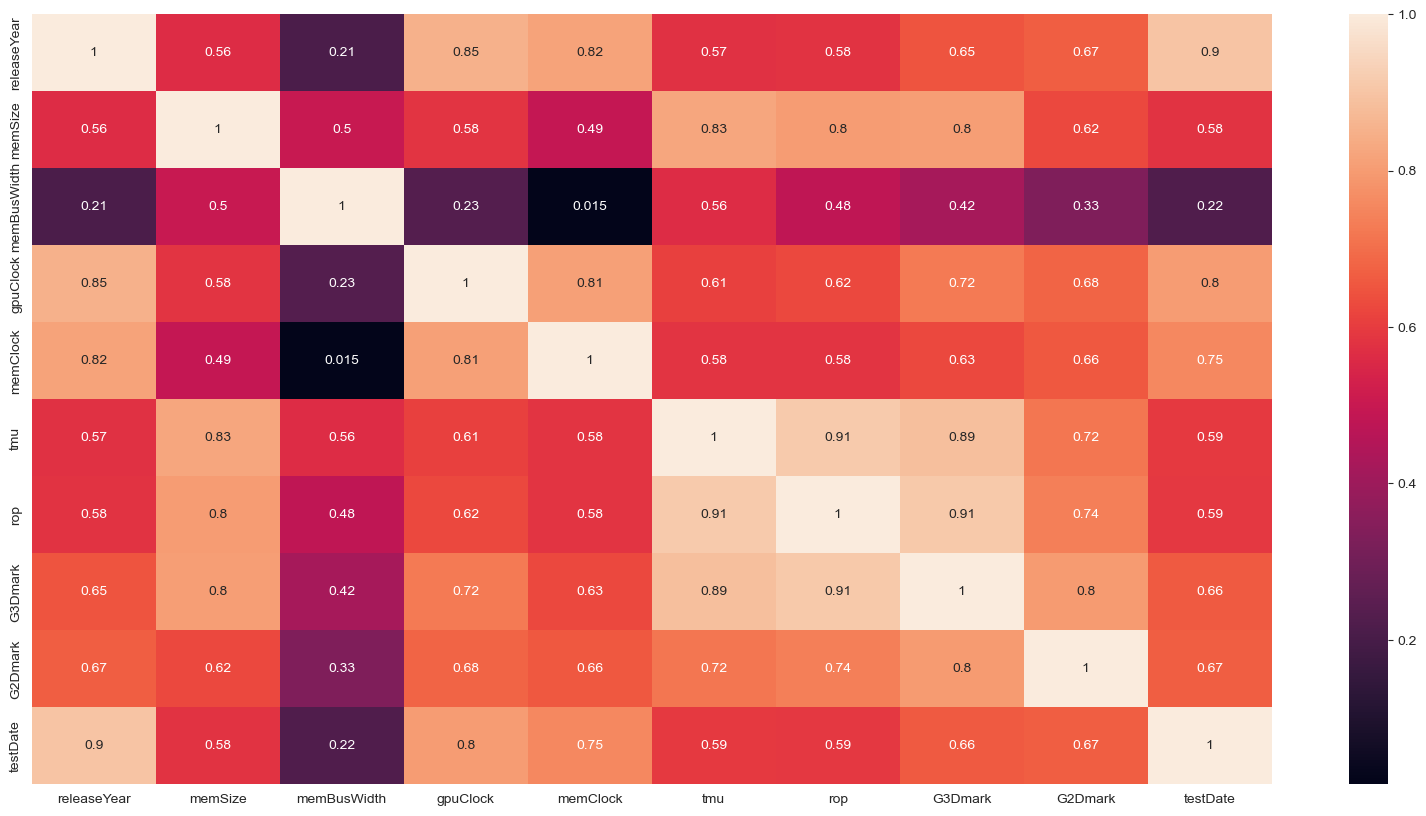

In [21]:
plt.figure(figsize = (20,10))
sns.heatmap(gpu_only_numeric.corr(), annot = True)
plt.savefig('heatmap.png',bbox_inches = 'tight', pad_inches = 1)

A few things to notice here: I don't think test date should really be considered here. It would follow that newer GPUs would have higher scores.

G2Dmark may be an obvious choice, but we can understand that if a GPU has a high 2Dmark score, a high 3Dmark score would follow.

It appears ROP, or the render output unit, is MOST correlated to our feature in question. The ROP is the final step in the rasterization process for modern GPUs; it's cool to see here how important it is to overall performance.

TMU, or texture mapping units, are next up and are almost as highly correlated to GPU performance as the ROPs.

Memory size, aka how much video memory does the GPU have, is next, and that would make sense. More powerful cards tend to have more memory, but that is not always the case. Memory size, based on my own domain knowledge, should not be considered by itself. What's more important is the type of memory. We didn't see that here as it's a categorical variable. We'll see that later.

It is important, it is impactful, but equating more video memory to higher performance would be wrong.

So we have G2DMark, ROP, TMU, memory clock speed, and GPU clock speed as our highest correlated features. That aligns with what my understanding was, but it's cool to see here.

we can visualize some of the above other ways too. Let's make scatter plots of G3Dmark score compared to our numerical features. 

In [8]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'G3Dmark', data=gpu, alpha=0.5)
        ax.set(xlabel=col, ylabel='G3DMark')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [9]:
features = [x for x in gpu.columns if x not in ['manufacturer', 'GPU', 'memType', 'category','bus', 'igp','gpuChip']]

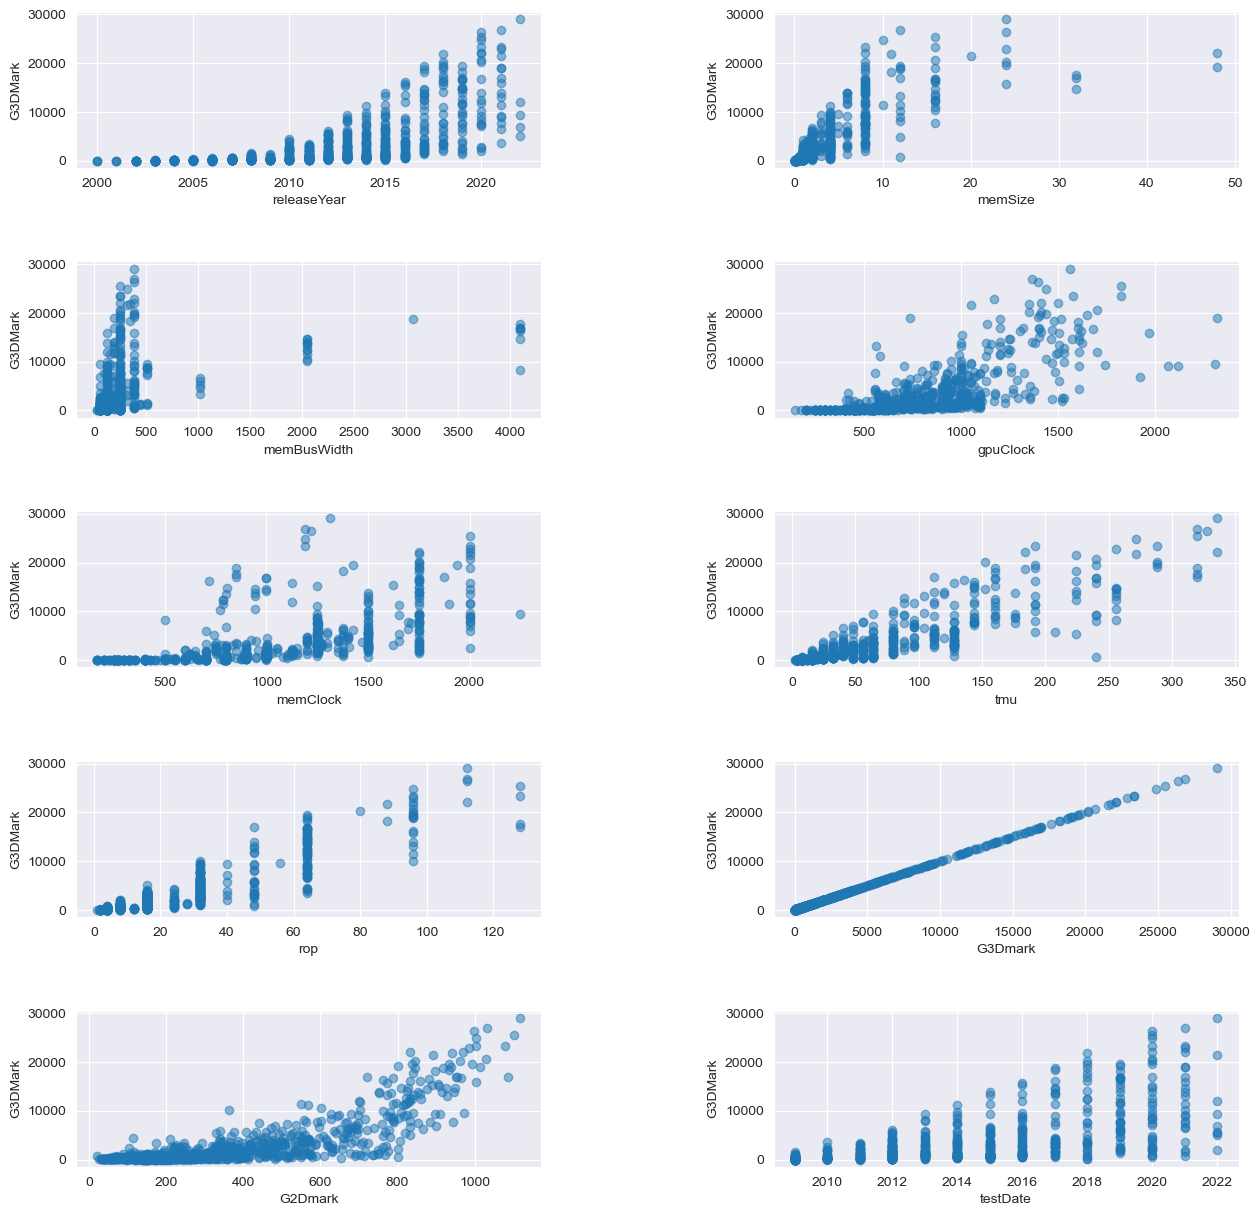

In [23]:
scatterplots(features, ncol=2, figsize=(15, 15))
sns.set_style('darkgrid')
plt.savefig('scatters.png',bbox_inches = 'tight', pad_inches = 1)

Well, this is interesting. Clearly for memory bus width, the same bus widths (aka, how much data can pass through the GPU at any given time) have simply gotten more efficient and more powerful with newer tech. Increasing the size of memory bus width does not appear to be as important as simply having newer and more powerful memory. TMU and ROP still hold a fairly strong positive correlation here. GPU clock and memory clock are kind of all over the place; it seems like they could be a similar story to memory bus width. You can still see some correlation between higher clock speeds and higher benchmark performance, but there are slower speeds outperforming higher speeds, and cards with the same speeds out performing each other, perhaps due to newer tech.

So our initial features still seem to hold the most correlation to benchmark performance. ROPs and TMUs show fairly clear correlation upwards, as well as G2Dmark. Our GPU Clock speeds seem fairly correlated too, but I'm less comfortable with using memory clock speeds as an indicator given their distribution.

First, I want to explore how memory clock speeds relate to memory type. Do newer types of memory come with faster clock speeds? I'll do the same for GPU clock speeds. 

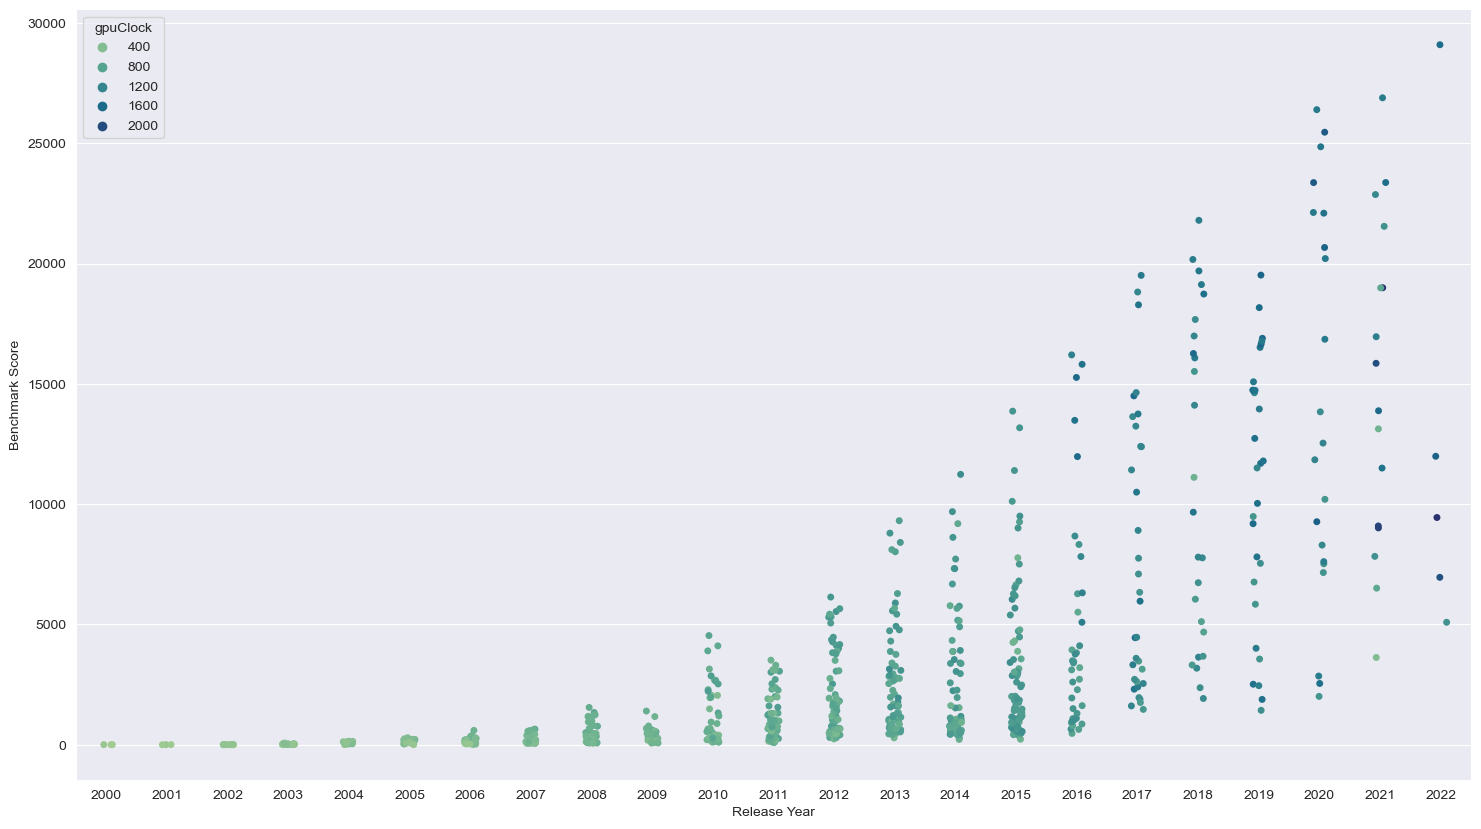

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
sns.stripplot(x = 'releaseYear', y = 'G3Dmark', data = gpu, palette = 'crest', hue = 'gpuClock')
plt.xlabel('Release Year')
plt.ylabel('Benchmark Score')
sns.despine()
plt.show()
plt.savefig('ReleaesYear.Benchmarks.ClockSpeeds.png',bbox_inches = 'tight', pad_inches = 1)

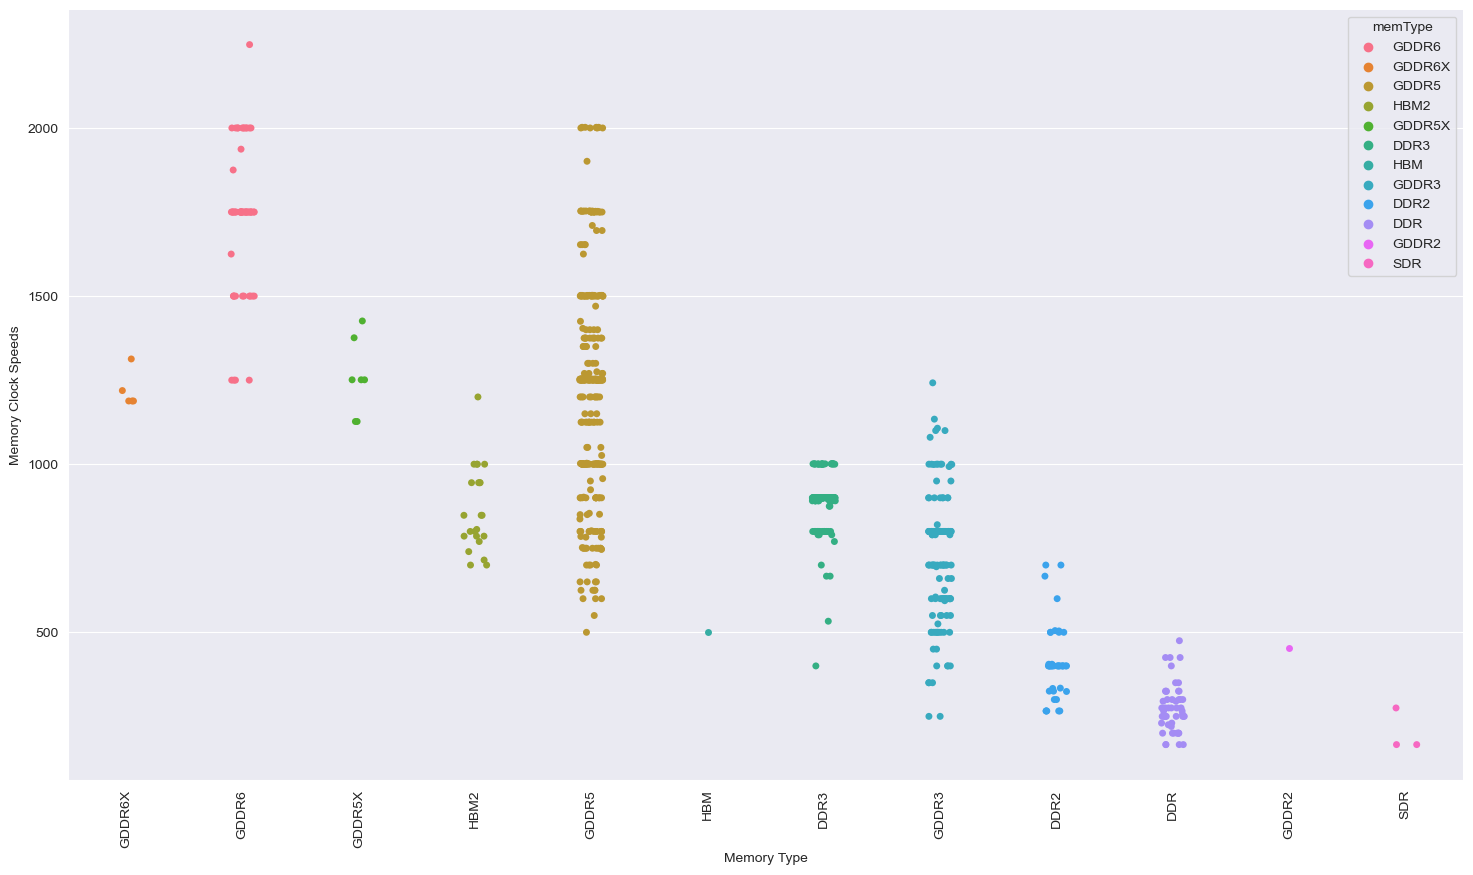

In [11]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'memType', y = 'memClock', data = gpu, hue = 'memType', order = cat_order)
plt.xticks(rotation = 90)
plt.xlabel('Memory Type')
plt.ylabel('Memory Clock Speeds')
sns.despine()
plt.show()

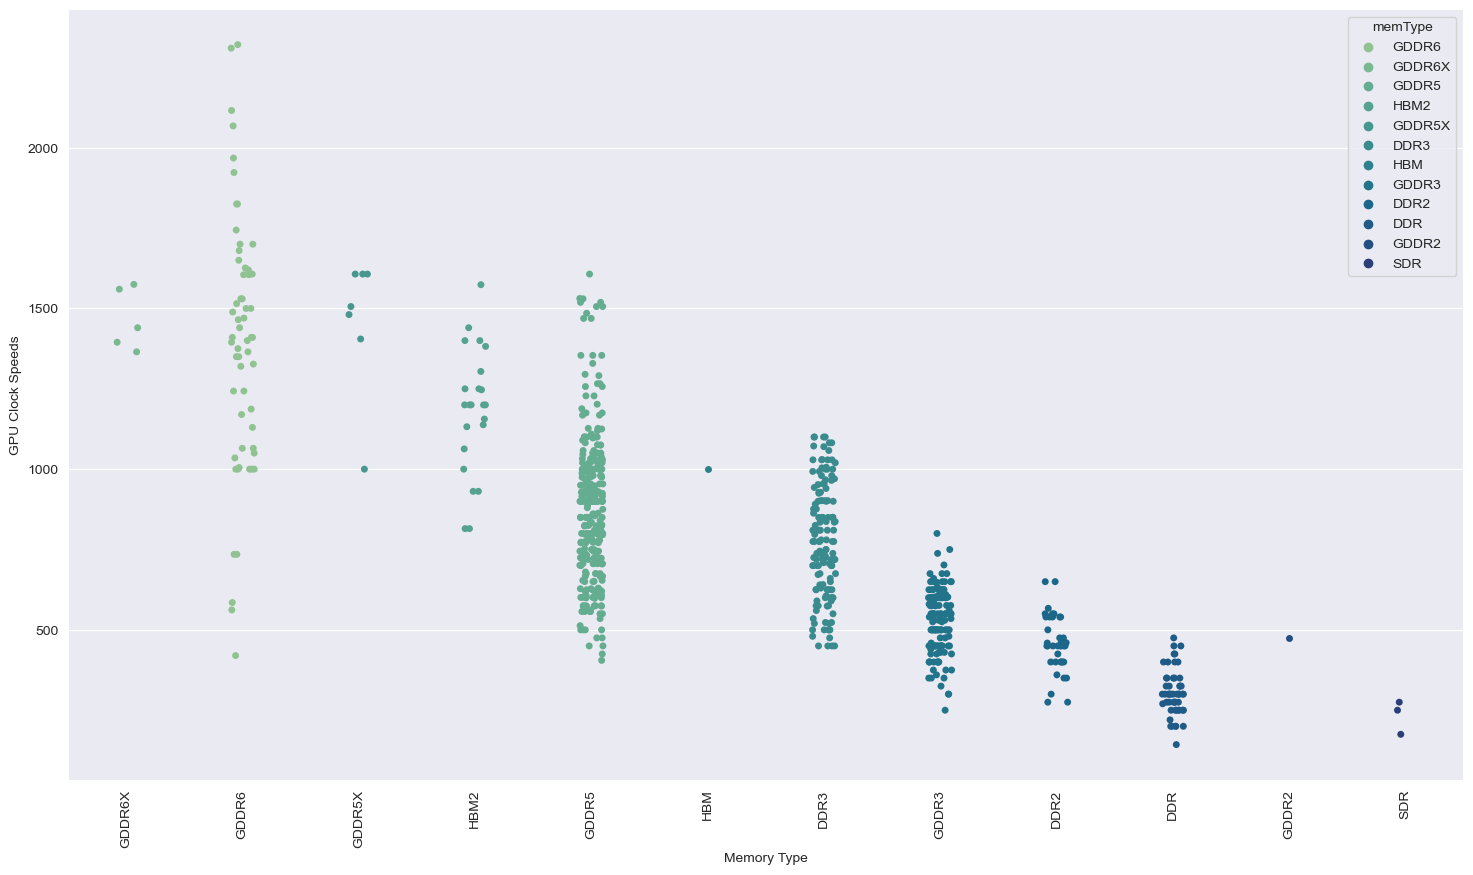

In [12]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'memType', y = 'gpuClock', data = gpu, hue = 'memType', order = cat_order, palette = 'crest')
plt.xticks(rotation = 90)
plt.xlabel('Memory Type')
plt.ylabel('GPU Clock Speeds')
sns.despine()
plt.show()

So yes, that does seem to be the case, but theres a faily large distrobution of values for both GPU and Memory Clock speeds for each type of memory. 

Have clock speeds gone up over time?

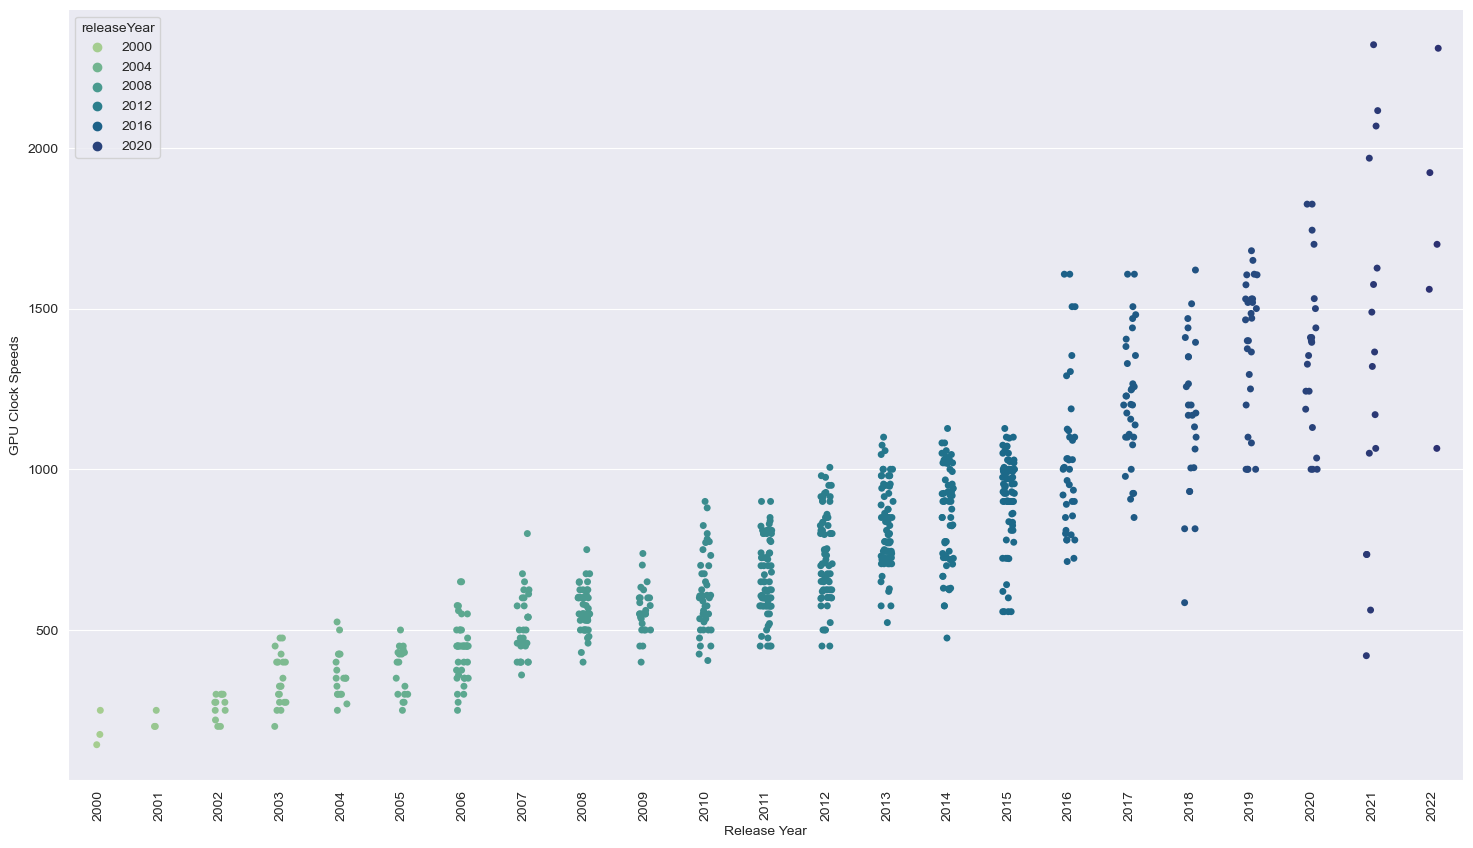

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'releaseYear', y = 'gpuClock', data = gpu, hue = 'releaseYear', palette = 'crest')
plt.xticks(rotation = 90)
plt.xlabel('Release Year')
plt.ylabel('GPU Clock Speeds')
sns.despine()
plt.show()
plt.savefig('Clock Speeds Vs Release Year.png', bbox_inches = 'tight', pad_inches = 1)

They have indeed. To be expexted. We see newer types of memory come with higher clock speeds, and that clock speeds have been going up over time, which of course can be related to knew standards for memory releasing over time. 

I'm now going to look at memory bus widths and see how they compare to bus types. Do wider widths correlate to newer bus types?

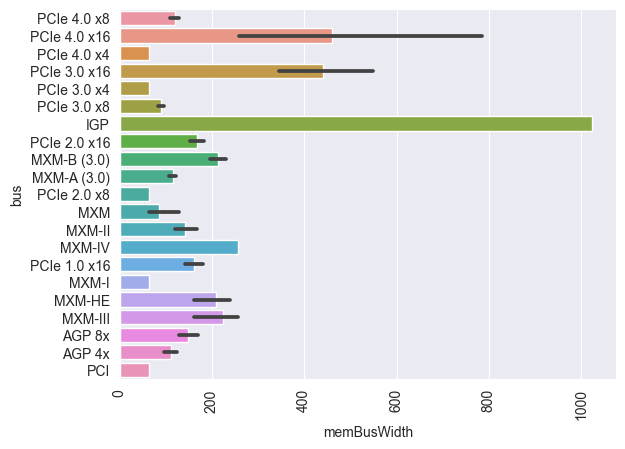

In [129]:
sns.barplot(x = 'memBusWidth', y = 'bus' ,data = gpu)
sns.set_style('darkgrid')
plt.xticks(rotation = 90)
plt.show()

Well, kind of. The newest standards of bus types do look to have wider bus widths here; maybe our scale on the scatter plots was too big to see the full picture. Look how PCIe 2.0 x8, PCIe 3.0 x8, and PCIe 4.0 x8 relate, each newer version of the x8 has seen larger bus widths. Same for x16. 

It would make sense that newer tech allows for more memory to pass through at any given time. 

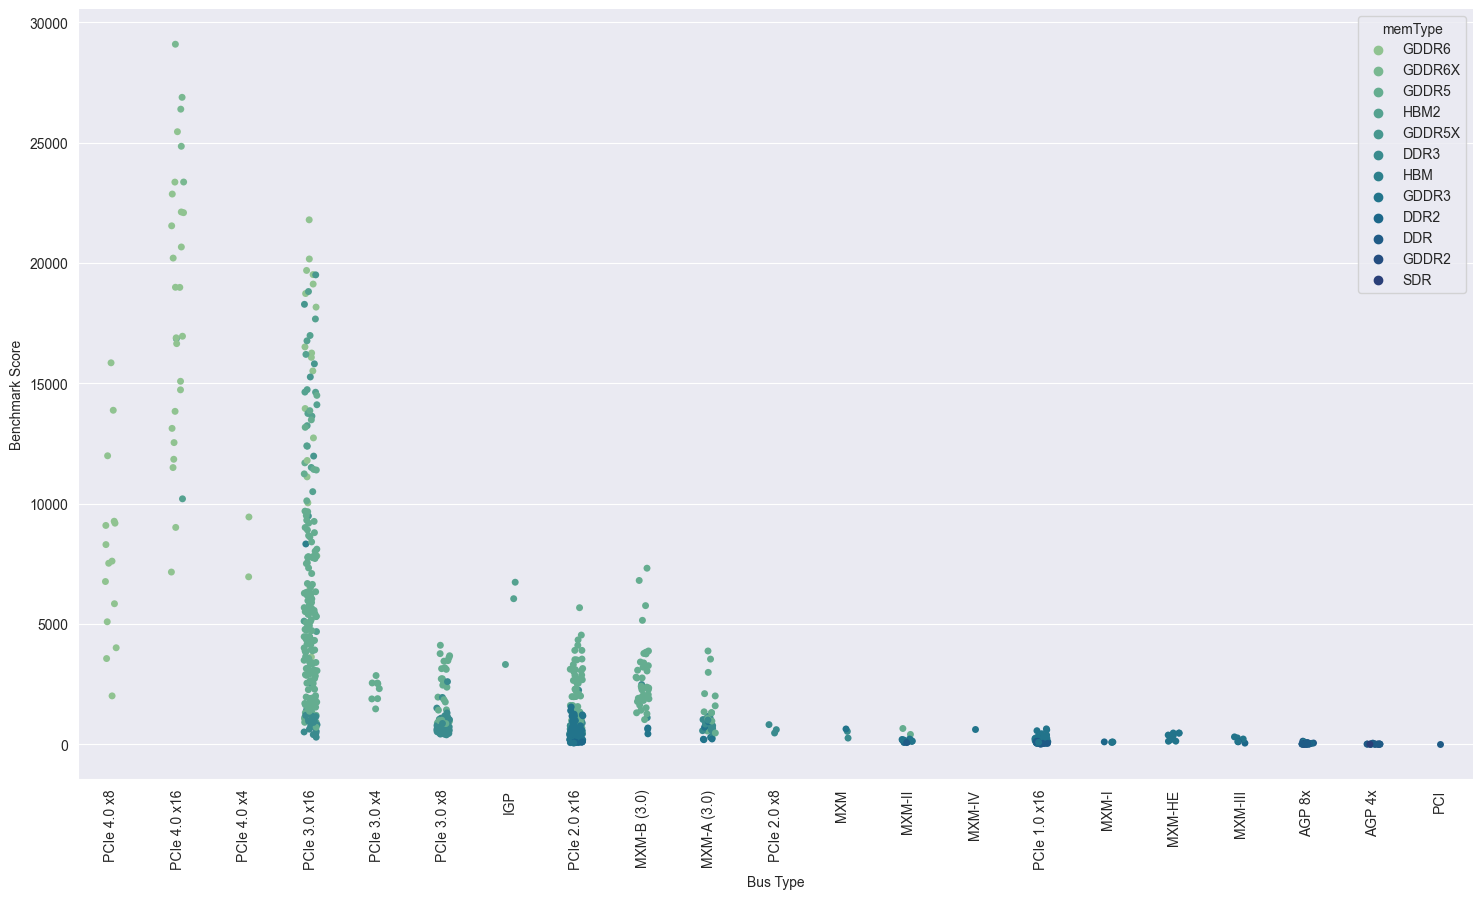

In [157]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
sns.stripplot(x = 'bus', y = 'G3Dmark', data = gpu, hue = 'memType', palette = 'crest')
plt.xticks(rotation = 90)
plt.xlabel('Bus Type')
plt.ylabel('Benchmark Score')
sns.despine()
plt.show()

Looks like newer bus types also correspond to higher performance. It seems reasonable to say newer bus types tend to come with larger bus widths, and those newer cards with larger widths tend to see higher performance. If a card can process more memory at once, it would likely see higher performance. 

Now I'll examine the type of video memory our GPUs have to visualize that cards with newer memory standards see higher performance. That's to be expected of course. 

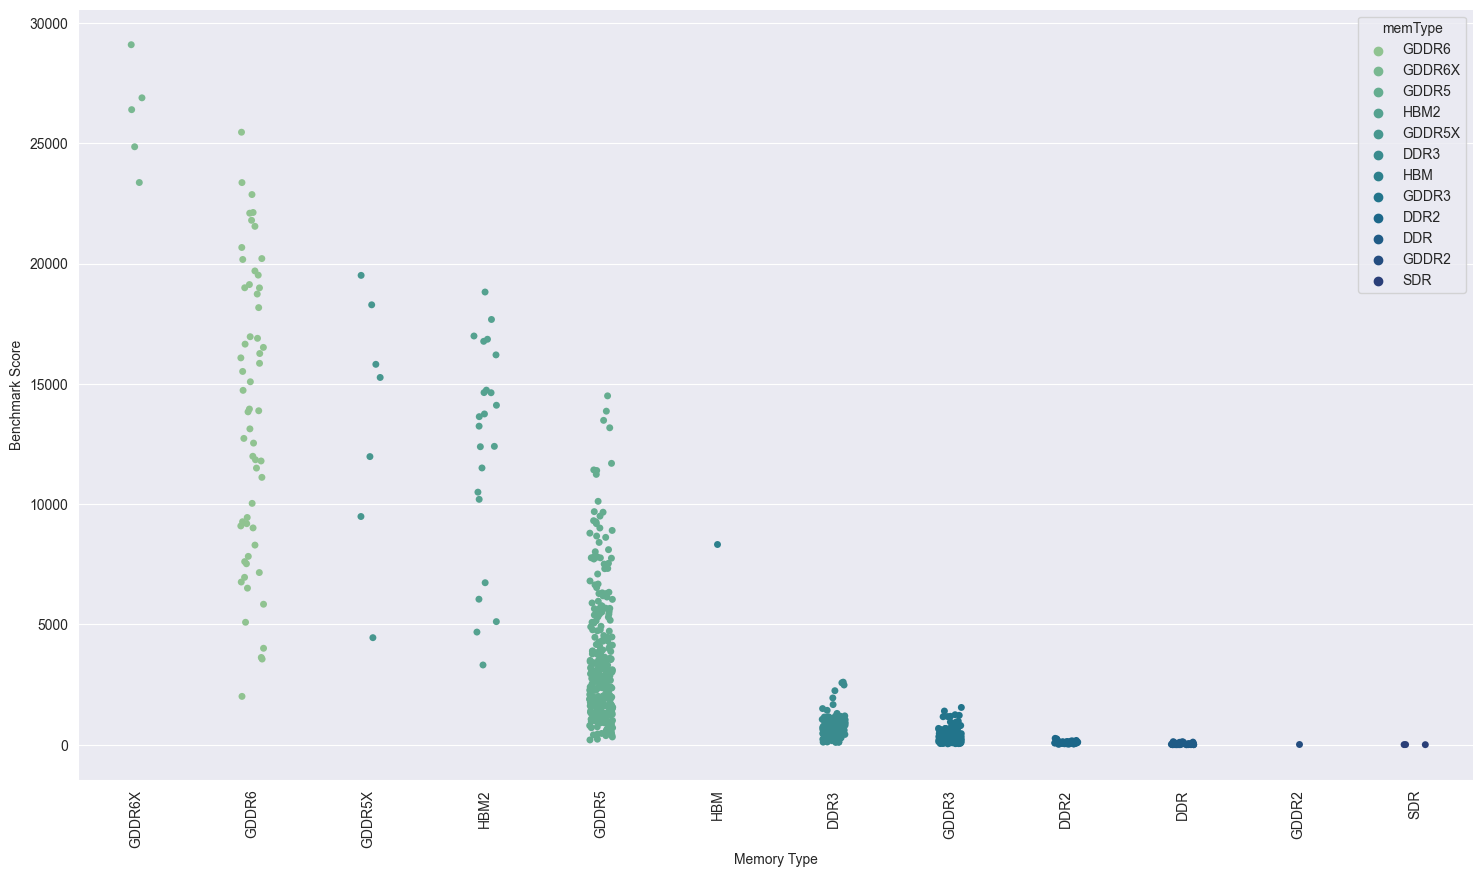

In [147]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'memType', y = 'G3Dmark', data = gpu, hue = 'memType', palette = 'crest',order = cat_order)
plt.xticks(rotation = 90)
plt.xlabel('Memory Type')
plt.ylabel('Benchmark Score')
sns.despine()
plt.show()

And there we go! The newest standard is GDDR6X and comes on the newest and most powerful cards, it would follow that it would see the highest scores, followed by the older standards almost exaclty as they've relreased!

Let's see if the newer memory standars (again, we can tie that back to newwe cards) tend to have higher rops and tmus, two our features we belive could be strong indicators of benchmark performance. 

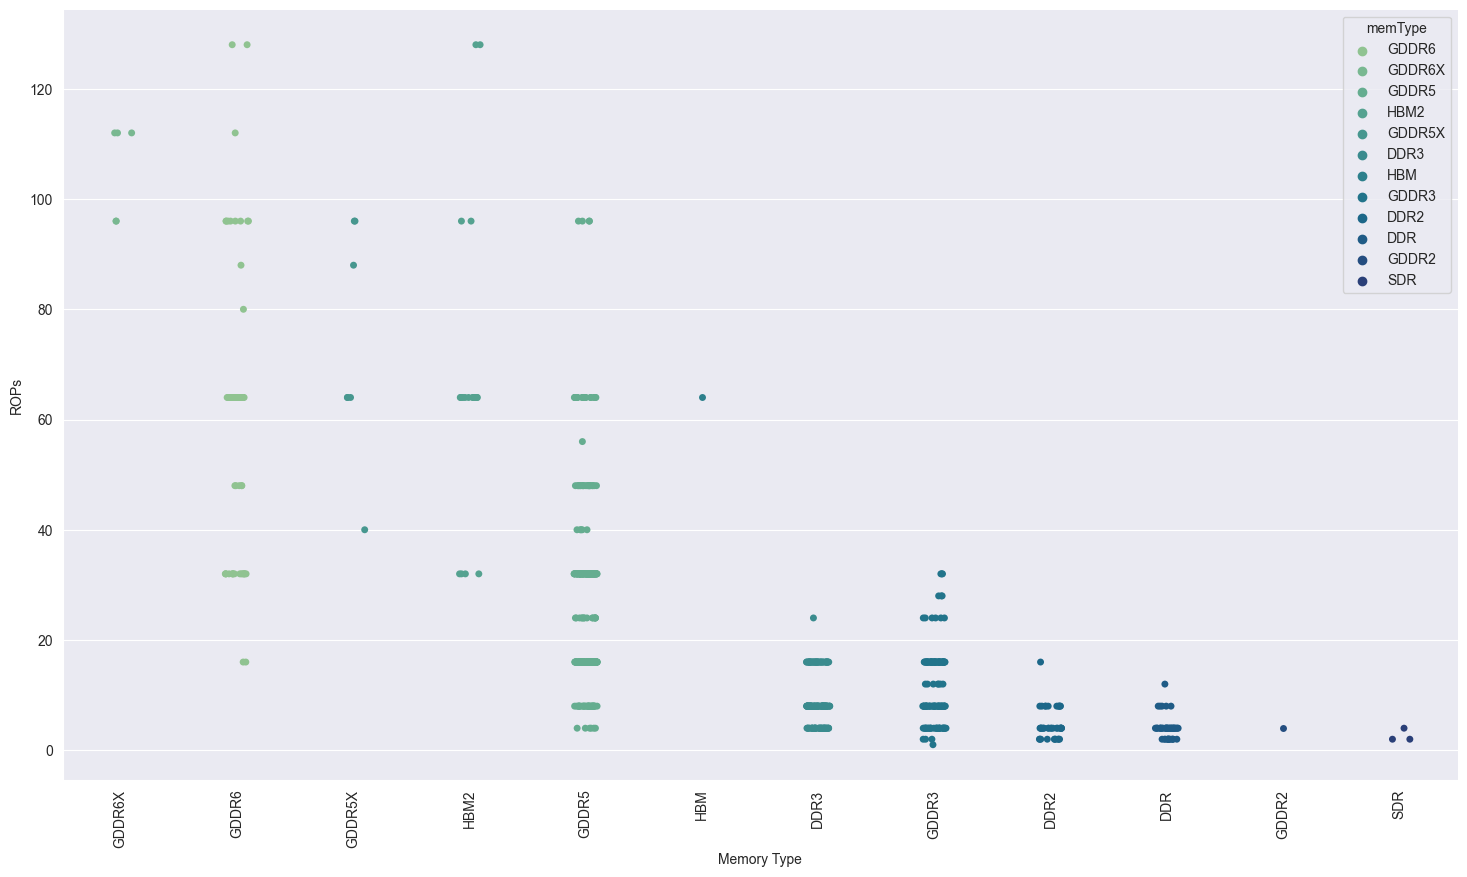

In [148]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'memType', y = 'rop', data = gpu, hue = 'memType', palette = 'crest', order = cat_order)
plt.xticks(rotation = 90)
plt.xlabel('Memory Type')
plt.ylabel('ROPs')
sns.despine()
plt.show()

It does look like that's the case, newer cards with newer memory standards tend to have more render output units. BUT, our GDDR6X cards saw the highest benchmark scores, though some GddR6 cards have more ROPs, once again pointing to the understanding that these numeric features are can only show so much. Time for TMU's. 

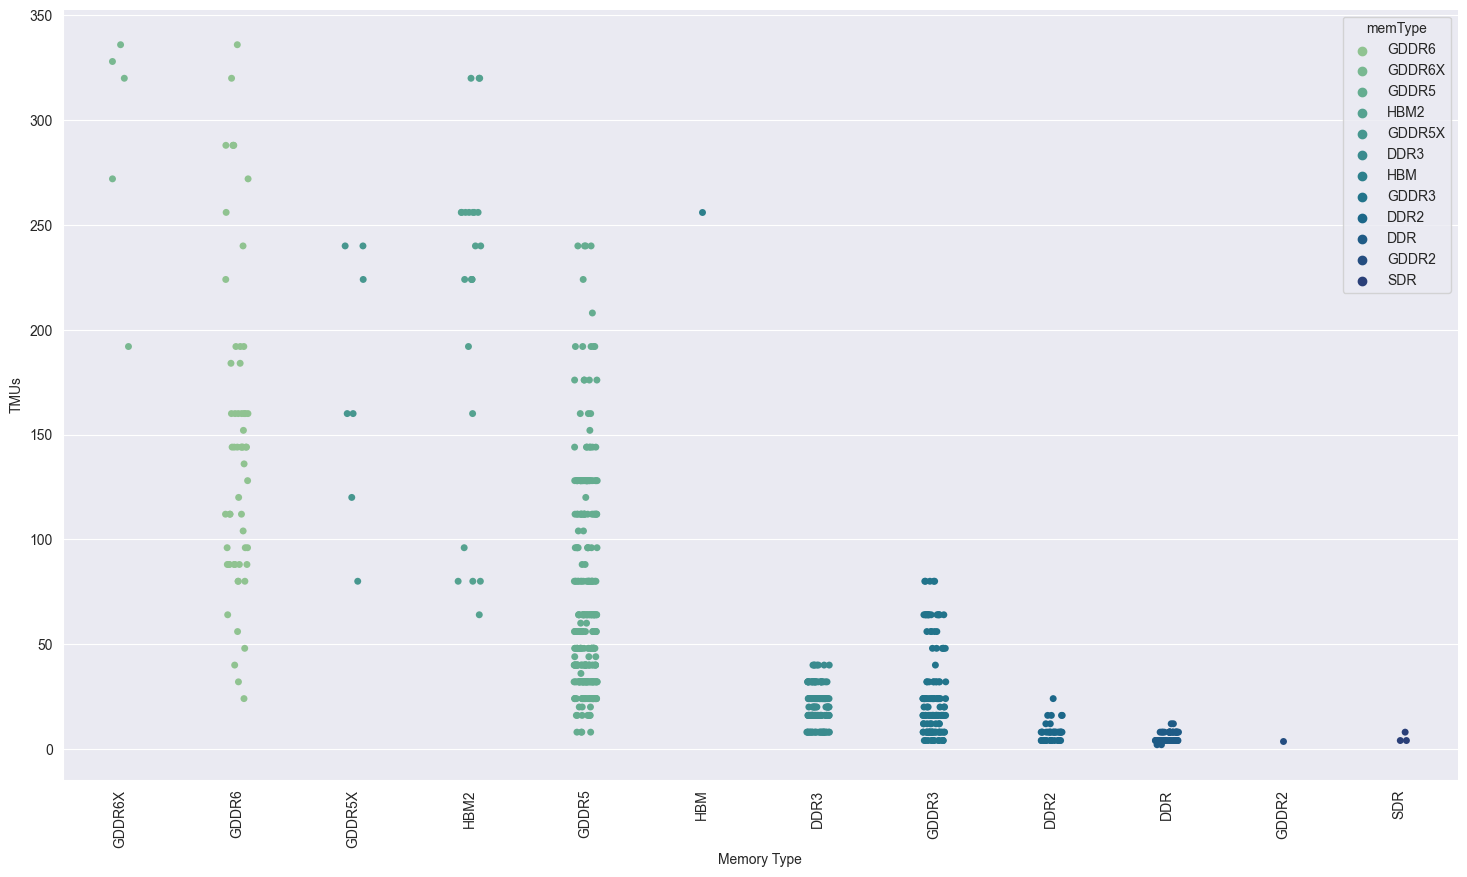

In [149]:
plt.figure(figsize = (18,10))
sns.set_style('darkgrid')
cat_order = ['GDDR6X', 'GDDR6', 'GDDR5X', 'HBM2', 'GDDR5','HBM','DDR3','GDDR3','DDR2','DDR','GDDR2','SDR']
sns.stripplot(x = 'memType', y = 'tmu', data = gpu, hue = 'memType',palette = 'crest', order = cat_order)
plt.xticks(rotation = 90)
plt.xlabel('Memory Type')
plt.ylabel('TMUs')
sns.despine()
plt.show()

Yeah, similar story here. Newer standards tend to come with more texture mapping units, and I'd bet that newer cards with more TMUs have higher benchmark scores.

I want to now visualize that newer cards tend to have more TMUs and ROPs. While it would be foolish to just assume more ROPs or TMUs by themselves mean more performance (failing to consider a new card may just have more efficient TMUs or ROPs), it can still be valuable to see those features increasing over time.

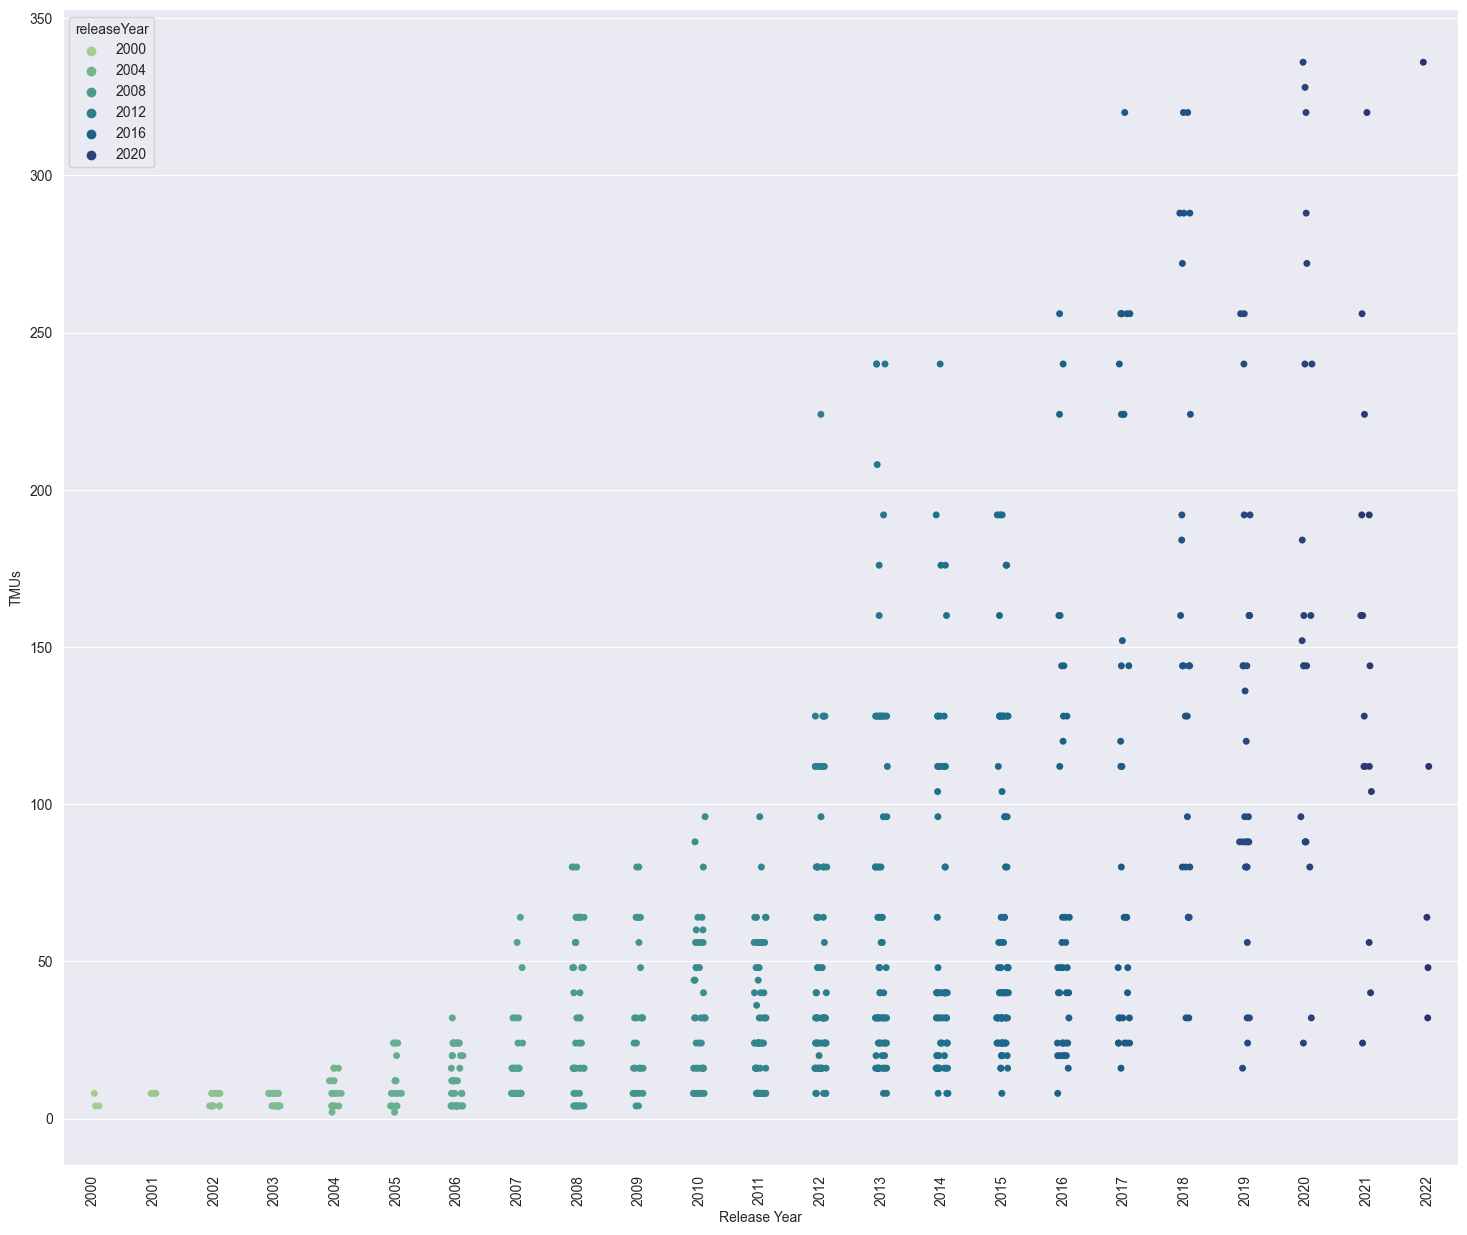

In [155]:
plt.figure(figsize = (18,15))
sns.set_style('darkgrid')
sns.stripplot(x = 'releaseYear', y = 'tmu', data = gpu, hue = 'releaseYear',palette = 'crest')
plt.xticks(rotation = 90)
plt.xlabel('Release Year')
plt.ylabel('TMUs')
sns.despine()
plt.show()

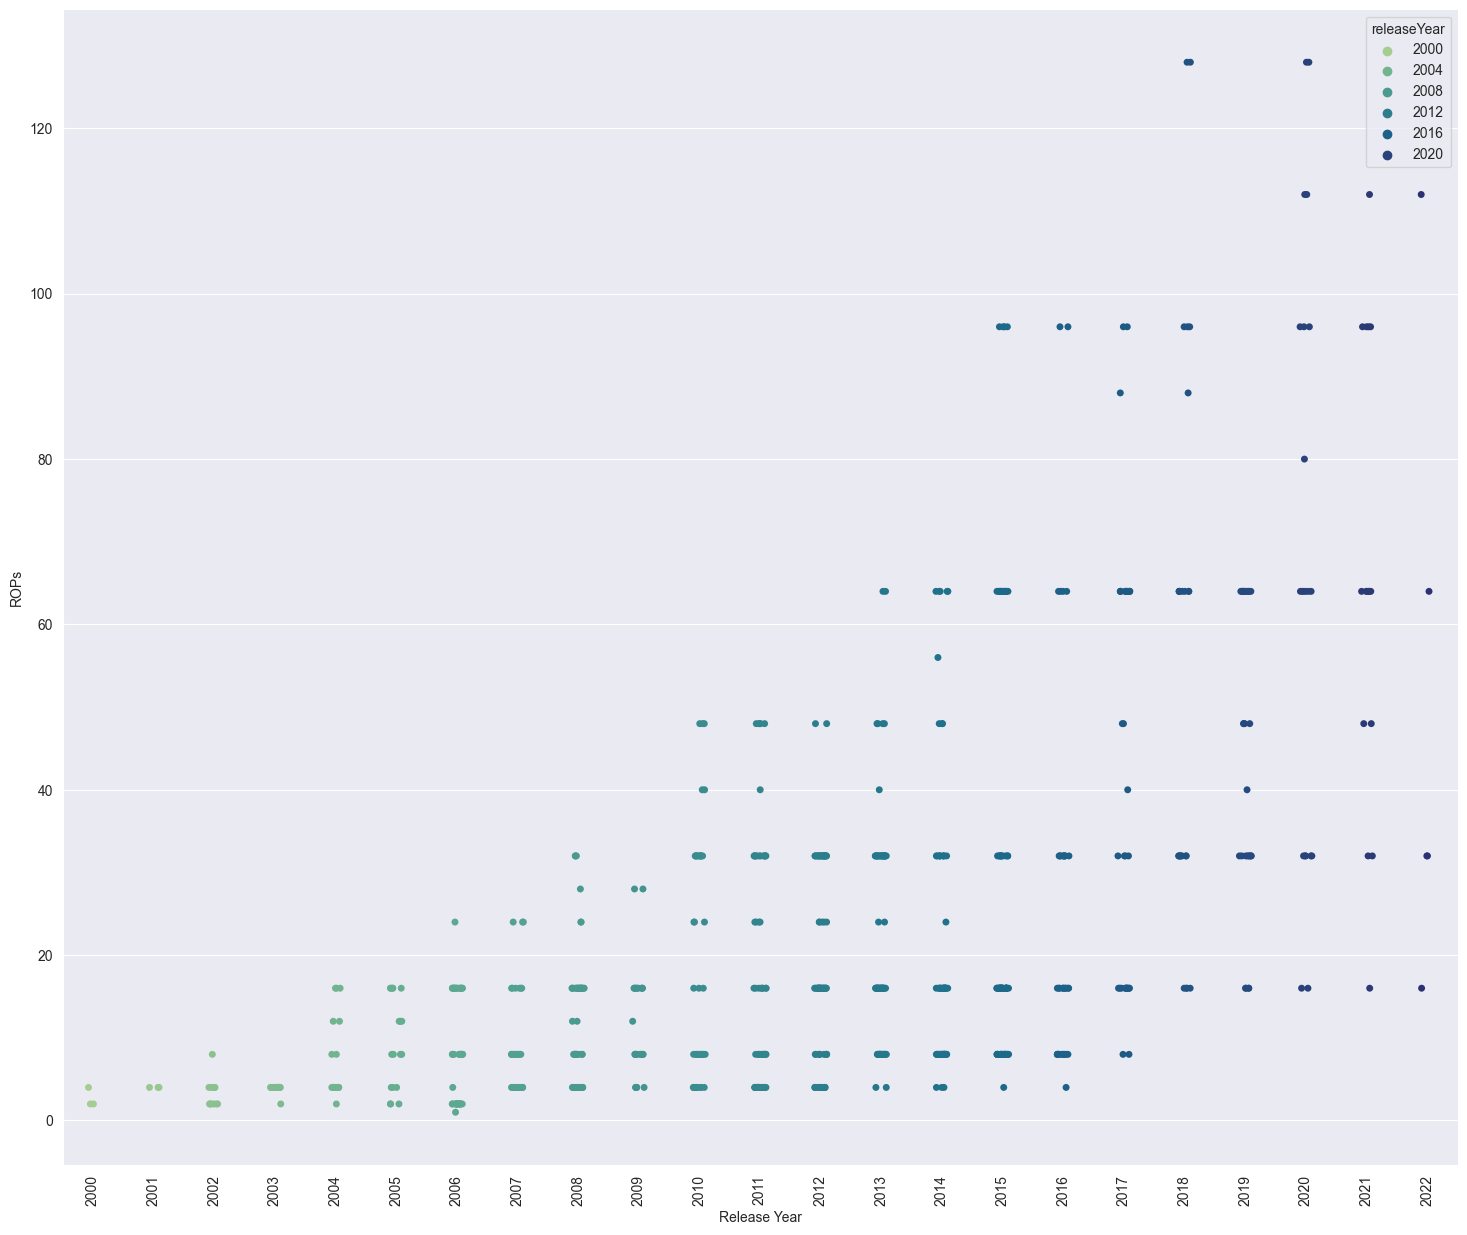

In [156]:
plt.figure(figsize = (18,15))
sns.set_style('darkgrid')
sns.stripplot(x = 'releaseYear', y = 'rop', data = gpu, hue = 'releaseYear', palette = 'crest')
plt.xticks(rotation = 90)
plt.xlabel('Release Year')
plt.ylabel('ROPs')
sns.despine()
plt.show()

Finally, I'll show a quick visual of 2Dmark score compared to 3Dmark score, perhaps the most obvious comparison. 

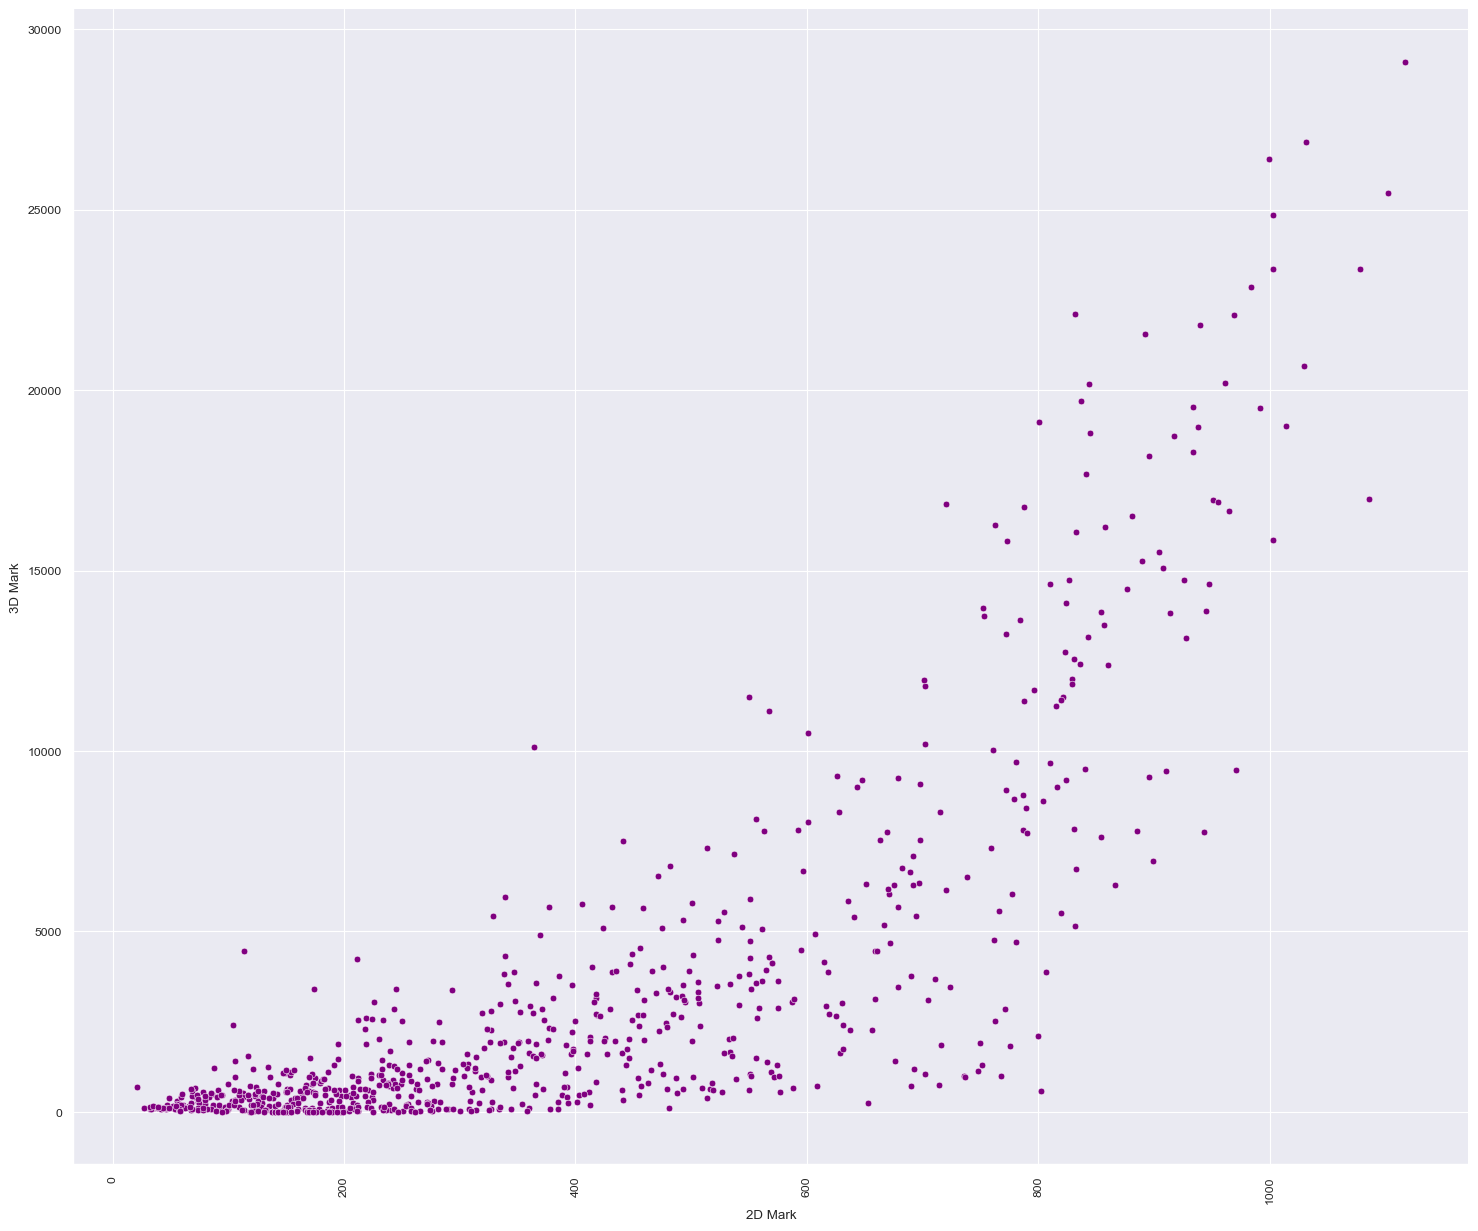

In [175]:
plt.figure(figsize = (18,15))
sns.set_style('darkgrid')
sns.scatterplot(x = 'G2Dmark', y = 'G3Dmark', data = gpu ,color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('2D Mark')
plt.ylabel('3D Mark')
sns.despine()
plt.show()

Yes, a great indicator of 3DMark performance. 

So what have I learned here? Our numerical features are important, but what's equally important is to tie those back to our categorical variables to understand that newer cards, with newer technologies, will perform better despite not necessarily holding higher clock speeds or more TMUs or ROPs.

Seems obvious to say now, but this has been eye-opening. You can't just say a card with more ROPs or TMUs will perform better. It must be understood that newer cards, with newer standards for memory, likely contain newer standards for ROPs and TMUs. So 200 ROPs or TMUs in a newer card will be faster than those same 200 in an older card.

Looking back at our scatterplots, there's still a fairly strong correlation between total TMUs/ROPs and higher performance, but those features must be examined with the fuller picture in mind. Same goes for Memory and GPU clocks. 

You could say this comes with domain knowledge and you'd be right, I just want to paint the clearest picutre possible moving forward. 

I will plan on using G2Dmark, TMUs, ROPs, GPU Clock Speeds, Bus, and Memory Type as my primary indicators of performance. I'm a bit worried with how to run a model with categorical features, I'll dicsuss that with my mentor. 

This last visual is more just out of curiousity, I understand its horribly hard to read and make sense of. 

In [173]:
sns.set_context('paper')
sns.relplot(x="gpuClock", y="G3Dmark", 
            data=gpu,
            kind="scatter",
            row = 'memType',
           col = 'bus')
plt.xlabel('GPU Clock')
plt.ylabel('Benchmark Score')

Text(10004.714814814814, 0.5, 'Benchmark Score')